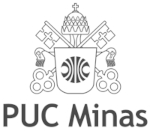

## Programa de Pós Graduação em Informática

### Disciplina: Natural Language Processing (NLP)

### Aluno: Felipe A. L. Reis

---
## Descrição do Método (TF-IDF)

O método TF-IDF foi desenvolvido de forma extremamente simples, para identificação de similaridade entre palavras e expressões semelhantes, na tentativa de classificação utilizando apenas esse critério.

Nesse modelo ingênuo, foram utilizadas técnicas de pré-processamento textual, como remoção de *stop_words*, além de aplicação de técnicas de *stemming* e *lematização*. O texto foi dividido de várias maneiras distintas, com aplicação de diferentes *tokenizers* fornecidos pela biblioteca [NLTK](https://www.nltk.org/).

As técnicas de *stemming*, como *PorterStemmer*, *SnowballStemmer*, *LancasterStemmer*, foram aplicadas individualmente às palavras existentes tanto **frase-âncora** quanto na **frase-alvo**, após a aplicação do processo de *lematização*. Essas palavras foram utilizadas na fase seguinte, quando foi gerada uma tabela TF-IDF.

A tabela TF-IDF contém a correlação entre os documentos e as palavras existentes na **frase-âncora** e as palavras existentes na **frase-alvo**. Tal tabela tem como objetivo apenas correlacionar as palavras e expressões semelhantes, de modo a formar um vetor esparso com essa informação.

Apesar da ausência de sinônimos na tabela TF-IDF, seu objetivo foi apenas identificar as palavras semelhantes, na tentativa de correlacionar as expressões apenas pela similaridade entre termos semelhantes, com um mesmo radical e com palavras semelhantes. O TF-IDF também foi aplicado com informações de contexto, para que melhores resultados pudessem ser obtidos.

Após a criação dessa tabela, foram utilizados regressores, que treinados sobre a tabela TF-IDF buscavam associar os valores existentes aos *scores*, realizando uma estimativa. Nessa tarefa, foram utilizados os seguites regressores:

* Regressor Linear;
* Regressor Ridge;
* Regressor Multilayer Perceptron (MLP);
* Regressor XGBoost;
* Regressores MLP e LSTM, usando Keras.

Os resultados obtidos pelo regressores MLP, com auxílio da biblioteca [Sciki-Learn](https://scikit-learn.org/) ou [Keras](https://www.tensorflow.org/guide/keras?hl=pt-br) tiveram o melhor desempenho nos testes locais. Nesses testes, o conjunto de treinamento foi subdividido e uma parte dele foi utilizada para avaliação dos resultados. 

---
## Importação de Bibliotecas

In [1]:
%load_ext autoreload
%autoreload 2
from nlputil import load_data, split_data, get_examples, do_lemma_stemmer
from nlputil import pre_process_codes, pre_process_data_codes
from nlputil import calcula_correlacao, calcula_mse

In [2]:
import datetime
import os, shutil
from scipy import stats
from scipy.sparse import csr_matrix
from scipy.stats import pearsonr

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.model_selection import KFold, RepeatedStratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import make_column_transformer

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

import xgboost as xgb

/home/falreis/anaconda3/envs/nlp/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [3]:
import re
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.tokenize import sent_tokenize, wordpunct_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer, SnowballStemmer, LancasterStemmer
from nltk.tag.perceptron import PerceptronTagger

'''
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('words')
nltk.download('omw-1.4')
'''

"\nnltk.download('punkt')\nnltk.download('wordnet')\nnltk.download('stopwords')\nnltk.download('averaged_perceptron_tagger')\nnltk.download('words')\nnltk.download('omw-1.4')\n"

In [24]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D
from tensorflow.keras.layers import LSTM, Bidirectional, Dropout, Dense, Flatten
from tensorflow.keras.optimizers import Adam

# código para algumas linhas de GPUs
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
assert tf.executing_eagerly()

---
## Aplicação de Pré Processamento Textual

In [5]:
test = load_data('dataset/test.csv')
data = load_data('dataset/train.csv')
codes = load_data('dicionario_dados/titles.csv')

codes = codes.drop(['subclass','group', 'main_group', 'section', 'class'], axis=1)

data

id        anchor                  target context  score
0      37d61fd2272659b1     abatement  abatement of pollution     A47   0.50
1      7b9652b17b68b7a4     abatement          act of abating     A47   0.75
2      36d72442aefd8232     abatement         active catalyst     A47   0.25
3      5296b0c19e1ce60e     abatement     eliminating process     A47   0.50
4      54c1e3b9184cb5b6     abatement           forest region     A47   0.00
...                 ...           ...                     ...     ...    ...
36468  8e1386cbefd7f245  wood article          wooden article     B44   1.00
36469  42d9e032d1cd3242  wood article              wooden box     B44   0.50
36470  208654ccb9e14fa3  wood article           wooden handle     B44   0.50
36471  756ec035e694722b  wood article         wooden material     B44   0.75
36472  8d135da0b55b8c88  wood article        wooden substrate     B44   0.50

[36473 rows x 5 columns]

#### Verificação Manual de Alguns Exemplos

In [6]:
get_examples(data)

id          anchor                target context  score
10278  0efddbd69f2a05bd        dry corn          dry zea mays     C12   0.75
10280  72566f5506a6bc7c        dry corn                grains     C12   0.25
10284  f1db3bc888f45df3        dry corn                solids     C12   0.00
10288  ade4f00e120d6fe7        dry corn              zea mays     C12   0.25
22237  52f027f8f0bbf90c  opposing walls        interior walls     F26   0.50
22239  c6a0bc8ef2f4128c  opposing walls               lengths     F26   0.25
22243  bcde39881cdea931  opposing walls  opposite inner walls     F26   0.50
22245  1c242ad34ec75d91  opposing walls        opposite sides     F26   0.25
22246  e44e2dcbc9f97273  opposing walls        opposite walls     F26   1.00
22247  d23713223cc6ec3e  opposing walls                 sides     F26   0.25
22248  3574ac0f83df6a13  opposing walls             sidewalls     F26   0.50
22249  76a0173e81e12b69  opposing walls                 walls     F26   0.50

#### Aplicação de Lematização, Stemmer e Análise de Exemplos

In [7]:
#data = do_lemma_stemmer(data)
#get_examples(data)

#### Agrupa Códigos

Agrupa códigos de 3o nível no código de 2o nível, para melhorar o contexto dos dados.
Após agrupar textos, esses são combinados em um único descritivo.

* A02 = A02A + A02B + ... + A02Z

In [8]:
codes = pre_process_codes(codes)
codes

code                                              title
0    A01   agriculture. forestry. animal husbandry. hunt...
1    A21   baking. edible doughs. bakers' ovens. machine...
2    A22   butchering. meat treatment. processing poultr...
3    A23   foods or foodstuffs. treatment thereof, not c...
4    A24   tobacco. cigars. cigarettes. simulated smokin...
..   ...                                                ...
131  H05   electric techniques not otherwise provided fo...
132  H99   subject matter not otherwise provided for in ...
133  Y02   technologies or applications for mitigation o...
134  Y04   information or communication technologies hav...
135  Y10   technical subjects covered by former uspc. te...

[136 rows x 2 columns]

#### Cria Entrada Dados

* União de Dados e Contexto (Classes)
* Cria Coluna combinando Anchor e Target 

Cria coluna combinando Anchor e Target, produzindo uma única entrada para ser treinada

In [9]:
data = pre_process_data_codes(data, codes)
test = pre_process_data_codes(test, codes)
data

id        anchor                  target context  score  \
0      37d61fd2272659b1     abatement  abatement of pollution     A47   0.50   
1      7b9652b17b68b7a4     abatement          act of abating     A47   0.75   
2      36d72442aefd8232     abatement         active catalyst     A47   0.25   
3      5296b0c19e1ce60e     abatement     eliminating process     A47   0.50   
4      54c1e3b9184cb5b6     abatement           forest region     A47   0.00   
...                 ...           ...                     ...     ...    ...   
36468  718f1c6953e3942f    undulation     undulatory swimmers     B31   0.00   
36469  4dc407e6d0aa7844    undulation       voltage fluctuate     B31   0.00   
36470  de69548ad79caccc  web transfer       transfer from web     B31   0.75   
36471  6620317413e6e03f  web transfer         transfer to web     B31   0.25   
36472  96946de83b530746  web transfer            transfer web     B31   0.75   

      code                                              title  
0      A47   furniture. domestic articles or appliances. c...  
1      A47   furniture. domestic articles or appliances. c...  
2      A47   furniture. domestic articles or appliances. c...  
3      A47   furniture. domestic articles or appliances. c...  
4      A47   furniture. domestic articles or appliances. c...  
...    ...                                                ...  
36468  B31   making articles of paper, cardboard or materi...  
36469  B31   making articles of paper, cardboard or materi...  
36470  B31   making articles of paper, cardboard or materi...  
36471  B31   making articles of paper, cardboard or materi...  
36472  B31   making articles of paper, cardboard or materi...  

[36473 rows x 7 columns]

---
## Solução usando TF-IDF

Aplica pré-processamento nos conjuntos de treinamento e testes (lemma, stemmer, word tokenizer, etc).

Cria vetores TF-IDF, com base nas colunas *anchor* e *target*, gerando uma matriz TF-IDF por documento (entrada no DataFrame).

In [10]:
#data = data[:5000]

In [11]:
columns = ['anchor','target'] #,'title']
data = do_lemma_stemmer(data, columns)
test = do_lemma_stemmer(test, columns)

vectorizer = TfidfVectorizer(tokenizer=word_tokenize, ngram_range=(1, 4)) #, max_features=40000) 
transformer = make_column_transformer((vectorizer, 'anchor'), (vectorizer, 'target')) #, (vectorizer, 'title'))

Divide os conjuntos de treinamento e testes, utilizando Holdout (na versão submetida para avaliação, os conjuntos não são divididos - o treinamento é feito em todo o conjunto, sem testes).

In [12]:
x_train, x_test, y_train, y_test = split_data(data, data.score.values, test_size=0.1)

Transforma os dados de treinamento no modelo TF-IDF.

In [13]:
t_train = transformer.fit_transform(x_train)
tx_test = transformer.transform(x_test[columns])

t_train

<32825x40129 sparse matrix of type '<class 'numpy.float64'>'
	with 227868 stored elements in Compressed Sparse Row format>

Exibe vocabulário de termos.

In [14]:
vocabulary = transformer.transformers_[0][1].vocabulary_
list(vocabulary)[0:10]

['wire',
 'grid',
 'polar',
 'wire grid',
 'grid polar',
 'wire grid polar',
 'offset',
 'tabl',
 'offset tabl',
 'rotor']

Multiplica a matriz TF-IDF pelos coluna de pesos do DataFrame original, para reduzir / aumentar a importância de termos similares.

In [15]:
'''
rows, cols = t_train.shape
mult = np.full((cols, rows), x_train['score']+.25).transpose()

mult_train = csr_matrix(np.multiply(t_train.todense(), mult))
mult_train
'''

"\nrows, cols = t_train.shape\nmult = np.full((cols, rows), x_train['score']+.25).transpose()\n\nmult_train = csr_matrix(np.multiply(t_train.todense(), mult))\nmult_train\n"

Compara a matriz original gerada, com a matriz cujos pesos foram multiplicados pelo *score* fornecido na base de dados.

In [16]:
features = lambda x: [y.replace(r'tfidfvectorizer-', '')[3:] for y in x]

In [17]:
dt1 = pd.DataFrame(t_train[0:10].toarray(), columns=features(transformer.get_feature_names_out()))
dt1

abat  abnorm  abnorm posit  abras  absorb  absorb properti  absorpt  \
0   0.0     0.0           0.0    0.0     0.0              0.0      0.0   
1   0.0     0.0           0.0    0.0     0.0              0.0      0.0   
2   0.0     0.0           0.0    0.0     0.0              0.0      0.0   
3   0.0     0.0           0.0    0.0     0.0              0.0      0.0   
4   0.0     0.0           0.0    0.0     0.0              0.0      0.0   
5   0.0     0.0           0.0    0.0     0.0              0.0      0.0   
6   0.0     0.0           0.0    0.0     0.0              0.0      0.0   
7   0.0     0.0           0.0    0.0     0.0              0.0      0.0   
8   0.0     0.0           0.0    0.0     0.0              0.0      0.0   
9   0.0     0.0           0.0    0.0     0.0              0.0      0.0   

   absorpt rate  acan  acceler  ...  zolpidem structur  zone  zone bell  zoo  \
0           0.0   0.0      0.0  ...                0.0   0.0        0.0  0.0   
1           0.0   0.0      0.0  ...                0.0   0.0        0.0  0.0   
2           0.0   0.0      0.0  ...                0.0   0.0        0.0  0.0   
3           0.0   0.0      0.0  ...                0.0   0.0        0.0  0.0   
4           0.0   0.0      0.0  ...                0.0   0.0        0.0  0.0   
5           0.0   0.0      0.0  ...                0.0   0.0        0.0  0.0   
6           0.0   0.0      0.0  ...                0.0   0.0        0.0  0.0   
7           0.0   0.0      0.0  ...                0.0   0.0        0.0  0.0   
8           0.0   0.0      0.0  ...                0.0   0.0        0.0  0.0   
9           0.0   0.0      0.0  ...                0.0   0.0        0.0  0.0   

   zoom  zoom capac  zoom factor  zoster  zoster virus  zoster virus infect  
0   0.0         0.0          0.0     0.0           0.0                  0.0  
1   0.0         0.0          0.0     0.0           0.0                  0.0  
2   0.0         0.0          0.0     0.0           0.0                  0.0  
3   0.0         0.0          0.0     0.0           0.0                  0.0  
4   0.0         0.0          0.0     0.0           0.0                  0.0  
5   0.0         0.0          0.0     0.0           0.0                  0.0  
6   0.0         0.0          0.0     0.0           0.0                  0.0  
7   0.0         0.0          0.0     0.0           0.0                  0.0  
8   0.0         0.0          0.0     0.0           0.0                  0.0  
9   0.0         0.0          0.0     0.0           0.0                  0.0  

[10 rows x 40129 columns]

#### Treina Regressor do Tipo Linear

In [18]:
linear = LinearRegression()
linear.fit(t_train, y_train)
#linear.fit(mult_train, y_train)

LinearRegression()

In [19]:
#realiza predições sobre o conjunto de testes e apura métricas
linear_pred = linear.predict(tx_test)

#imprime correlação
print(pearsonr(y_test, linear_pred))

calcula_correlacao(y_test, linear_pred)

(0.4935015127624771, 2.819988134327405e-223)


true      pred
true  1.000000  0.497092
pred  0.497092  1.000000

#### Treina Regressor do Tipo Ridge

In [20]:
ridge = Ridge(alpha=0.1)
ridge.fit(t_train, y_train)

Ridge(alpha=0.1)

In [21]:
#realiza predições sobre o conjunto de testes e apura métricas
ridge_pred = ridge.predict(tx_test)

#imprime correlação
print(pearsonr(y_test, ridge_pred))
calcula_correlacao(y_test, ridge_pred)

(0.5487189005310452, 5.735458910836959e-286)


true      pred
true  1.000000  0.549647
pred  0.549647  1.000000

#### Treina Regressor do Tipo MLP

In [28]:
mlp = MLPRegressor(max_iter=50, learning_rate='adaptive')
mlp.fit(t_train, y_train)
#mlp.fit(mult_train, y_train)

/home/falreis/anaconda3/envs/nlp/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:699: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


MLPRegressor(learning_rate='adaptive', max_iter=50)

In [29]:
#realiza predições sobre o conjunto de testes e apura métricas
mlp_pred = mlp.predict(tx_test)

#imprime correlação 
print(pearsonr(y_test, ridge_pred))
calcula_correlacao(y_test, mlp_pred)

(0.5706666553859109, 2.5712284873e-314)


true      pred
true  1.000000  0.523707
pred  0.523707  1.000000

#### Treina Regressor utilizando Keras

In [24]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [ ]:
keras_x = t_train.todense() #//shape - (3,6,1) 
keras_y = y_train #//shape - (3,6,1)

Adam = tf.keras.optimizers.Adam(learning_rate=0.001)

model = Sequential()
model.add(Dense(128, input_dim = keras_x.shape[1], kernel_initializer='normal', activation='relu'))
model.add(Dense(64, kernel_initializer='normal', activation='relu'))
model.add(Dense(1, activation='linear', kernel_initializer='normal'))
#model.compile(loss='mae', optimizer=Adam, metrics = ['mse', 'accuracy'])

#model.add(LSTM(units=6, input_shape = keras_x.shape[1:], return_sequences = True))
#model.add(LSTM(units=6, return_sequences=True))
#model.add(LSTM(units=6, return_sequences=True))
#model.add(LSTM(units=1, return_sequences=True, name='output'))
#model.compile(loss='mae', optimizer='sgd', metrics = ['accuracy'])

print(model.summary())

model.fit(keras_x, keras_y, epochs=10, verbose=1, batch_size=2)

In [26]:
#realiza predições sobre o conjunto de testes e apura métricas
keras_pred = model.predict(tx_test.todense())
keras_pred = keras_pred[:, 0]

#imprime correlação
print(pearsonr(y_test, ridge_pred))
calcula_correlacao(y_test, keras_pred)

(0.5793019324315556, 0.0)


true      pred
true  1.000000  0.618795
pred  0.618795  1.000000

---
### Calcula os Testes

Gera os arquivos de testes usados para submissão.

In [29]:
final_test = transformer.transform(test[columns])
final_pred = model.predict(final_test)
final_pred = final_pred[:, 0]

final_pred = np.where(final_pred<0, 0, final_pred)
final_pred = np.where(final_pred>1, 1, final_pred)

#gera arquivo de submissão
test['score'] = final_pred
test

submission = test[['id','score']]
submission

id     score
0   4112d61851461f60  0.247794
1   5203a36c501f1b7c  0.717189
2   7aa5908a77a7ec24  0.249969
3   09e418c93a776564  0.546427
4   36baf228038e314b  0.610719
5   b892011ab2e2cabc  0.604344
6   1f37ead645e7f0c8  0.281088
7   71a5b6ad068d531f  0.000000
8   16ae4b99d3601e60  0.248320
9   474c874d0c07bd21  0.397978
10  442c114ed5c4e3c9  0.475897
11  b8ae62ea5e1d8bdb  0.012254
12  faaddaf8fcba8a3f  0.248807
13  ae0262c02566d2ce  1.000000
14  a8808e31641e856d  0.248330
15  25c555ca3d5a2092  0.642123
16  b9fdc772bb8fd61c  0.720206
17  d19ef3979396d47e  0.249682
18  7e3aff857f056bf9  0.005860
19  fd83613b7843f5e1  0.016261
20  2a619016908bfa45  0.531909
21  733979d75f59770d  0.497863
22  6546846df17f9800  0.252274
23  3ff0e7a35015be69  0.249109
24  12ca31f018a2e2b9  0.249475
25  03ba802ed4029e4d  0.250401
26  25522ee5411e63e9  0.248775
27  c404f8b378cbb008  0.521460
28  78243984c02a72e4  0.000000
29  de51114bc0faec3e  0.005940
30  26c3c6dc6174b589  0.010428
31  8247ff562ca185cc  0.008198
32  c057aecbba832387  0.009523
33  9f2279ce667b21dc  0.826198
34  b9ea2b06a878df6f  0.448058
35  79795133c30ef097  0.247561

In [30]:
submission.to_csv('submission.csv', index=False)